# Importing Systematic Training and Test Set csv Files

In [ ]:
from pandas import read_csv
import pandas as pd

# Specify the encoding as detected ('ascii')
train_data = pd.read_csv('/content/SRS_train_data.csv', encoding='ascii')  # Updated encoding to 'ascii'

test_data = pd.read_csv('/content/SRS_test_data.csv', encoding='ascii')  # Updated encoding to 'ascii'

# RQ1 - Performing K-Means Clustering

## Encoding Categorical Attributes, Standardizing Numerical Attributes, Handling Missing Values, PCA, & Finding Optimal Amount of Clusters (Elbow Method & Silhouette Scores)

Training set size: (21000, 86)
Test set size: (9000, 86)
Optimal number of clusters: 3


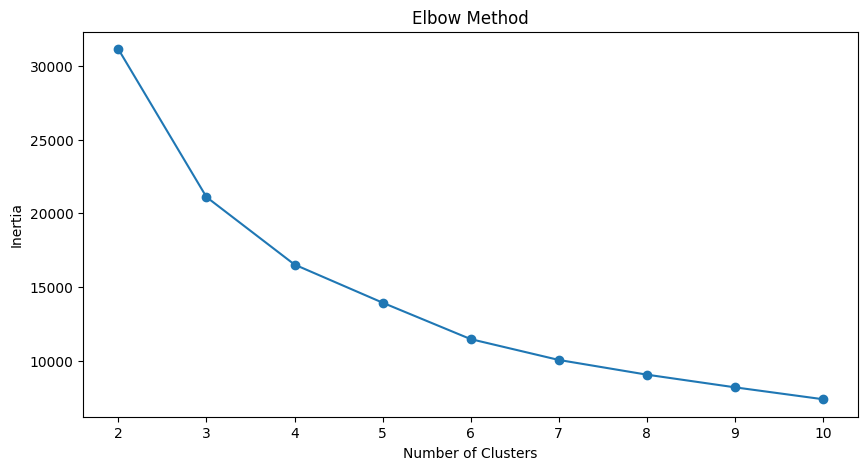

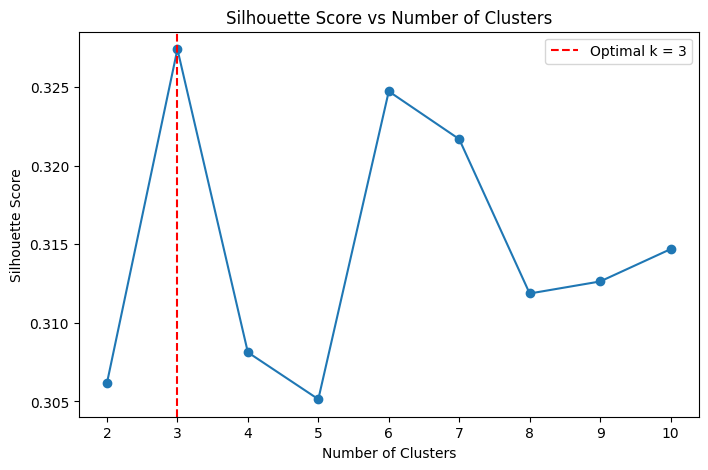

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Your existing split (just for clarity here)
# train_data, test_data = train_test_split(sampled_data, test_size=0.3, random_state=42, shuffle=True)

print(f"Training set size: {train_data.shape}")
print(f"Test set size: {test_data.shape}")

# Identify numerical and categorical columns in train data
numerical_cols = train_data.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_data.select_dtypes(include=['object']).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numerical_cols),

    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]), categorical_cols)
])

# Function to find optimal number of clusters
def find_optimal_k(data, preprocessor, k_range=(2, 11)):
    inertia = []
    silhouette_avg = []
    for k in range(*k_range):
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('pca', PCA(n_components=2)),
            ('kmeans', KMeans(n_clusters=k, random_state=42, n_init=10))
        ])
        labels = pipeline.fit_predict(data)
        pca_data = pipeline.named_steps['pca'].transform(
            pipeline.named_steps['preprocessor'].transform(data)
        )
        inertia.append(pipeline.named_steps['kmeans'].inertia_)
        silhouette_avg.append(silhouette_score(pca_data, labels))
    optimal_k = np.argmax(silhouette_avg) + k_range[0]
    return optimal_k, inertia, silhouette_avg

# Find optimal clusters on training data
optimal_k, inertia, silhouette_avg = find_optimal_k(train_data, preprocessor)
print(f"Optimal number of clusters: {optimal_k}")

# Plot Elbow method
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Plot Silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_avg, marker='o')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.legend()
plt.show()

# Final clustering pipeline with optimal k
clustering_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=2)),
    ('kmeans', KMeans(n_clusters=optimal_k, random_state=42, n_init=10))
])

# Fit on train data and assign clusters
train_clusters = clustering_pipeline.fit_predict(train_data)
train_data = train_data.copy()
train_data['cluster'] = train_clusters

# Predict clusters on test data
test_clusters = clustering_pipeline.predict(test_data)
test_data = test_data.copy()
test_data['cluster'] = test_clusters

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 87 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_id                21000 non-null  int64  
 1   age                        21000 non-null  int64  
 2   gender                     21000 non-null  object 
 3   income_bracket             21000 non-null  object 
 4   loyalty_program            21000 non-null  object 
 5   membership_years           21000 non-null  int64  
 6   churned                    21000 non-null  object 
 7   marital_status             21000 non-null  object 
 8   number_of_children         21000 non-null  int64  
 9   education_level            21000 non-null  object 
 10  occupation                 21000 non-null  object 
 11  transaction_id             21000 non-null  int64  
 12  product_id                 21000 non-null  int64  
 13  product_category           21000 non-null  obj

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 87 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_id                9000 non-null   int64  
 1   age                        9000 non-null   int64  
 2   gender                     9000 non-null   object 
 3   income_bracket             9000 non-null   object 
 4   loyalty_program            9000 non-null   object 
 5   membership_years           9000 non-null   int64  
 6   churned                    9000 non-null   object 
 7   marital_status             9000 non-null   object 
 8   number_of_children         9000 non-null   int64  
 9   education_level            9000 non-null   object 
 10  occupation                 9000 non-null   object 
 11  transaction_id             9000 non-null   int64  
 12  product_id                 9000 non-null   int64  
 13  product_category           9000 non-null   objec

### Saving Updated Train and Test set files with Cluster Added

In [ ]:
train_data.to_csv('srsstat_train_data.csv', index=False)
test_data.to_csv('srsstat_test_data.csv', index=False)

## Visualizing PCA1 & PC2

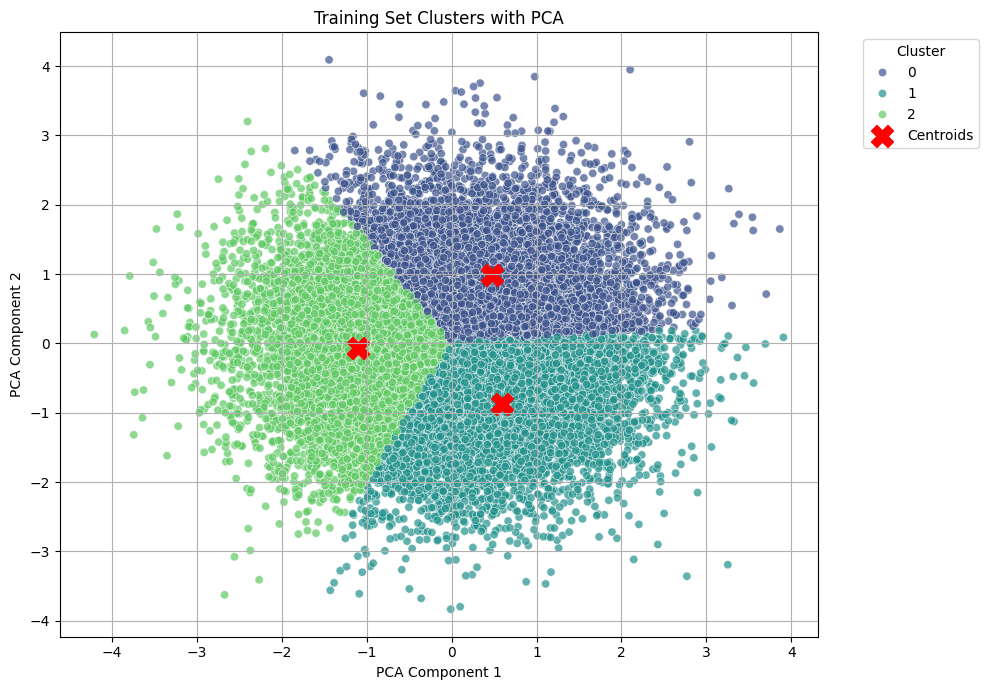

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Transform and create PCA DataFrame
X_pca = clustering_pipeline.named_steps['pca'].transform(
    clustering_pipeline.named_steps['preprocessor'].transform(train_data.drop(columns='cluster'))
)
pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])

# Step 2: Convert cluster to categorical with all possible categories
unique_clusters = sorted(train_data['cluster'].unique())
pca_df['cluster'] = pd.Categorical(train_data['cluster'], categories=unique_clusters)

# Step 3: Get KMeans centroids (in PCA space, since PCA comes before KMeans in the pipeline)
centroids = clustering_pipeline.named_steps['kmeans'].cluster_centers_

# Step 4: Plot with all clusters in legend
plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='cluster', palette='viridis', alpha=0.7)

plt.scatter(centroids[:, 0], centroids[:, 1], s=250, c='red', marker='X', label='Centroids')

plt.title('Training Set Clusters with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()


## Analyzing Cluster Characteristics

### Top contributors to PC1 & PC2

In [ ]:
# Get the preprocessed feature names
encoded_features = clustering_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Get PCA loadings (components)
loadings = pd.DataFrame(clustering_pipeline.named_steps['pca'].components_.T,
                        columns=['PC1', 'PC2'],
                        index=encoded_features)

# Sort features by absolute contribution to PC1
print("\nTop contributors to PC1:")
print(loadings['PC1'].abs().sort_values(ascending=False).head(50))

# Sort features by absolute contribution to PC2
print("\nTop contributors to PC2:")
print(loadings['PC2'].abs().sort_values(ascending=False).head(50))



Top contributors to PC1:
num__product_review_count         0.351882
num__days_since_last_purchase     0.320798
num__product_id                   0.241713
num__customer_support_calls       0.233369
num__online_purchases             0.211415
num__total_sales_over_lastyear    0.208249
num__membership_years             0.204593
num__product_manufacture_month    0.185465
num__discount_applied             0.185125
num__product_rating               0.182346
num__unit_price                   0.178142
num__month_of_year                0.176988
num__promotion_end_month          0.172365
num__customer_zip_code            0.165675
num__product_shelf_life           0.165615
num__avg_discount_used            0.160294
num__transaction_hour             0.155844
num__min_single_purchase_value    0.155182
num__total_returned_items         0.151874
num__product_stock                0.147231
num__week_of_year                 0.135114
num__transaction_year             0.129924
num__transaction_id         

#### Visual

<ipython-input-8-1978847619>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x=top_pc1.values, y=top_pc1.index, palette='Blues_r')
<ipython-input-8-1978847619>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x=top_pc2.values, y=top_pc2.index, palette='Oranges_r')


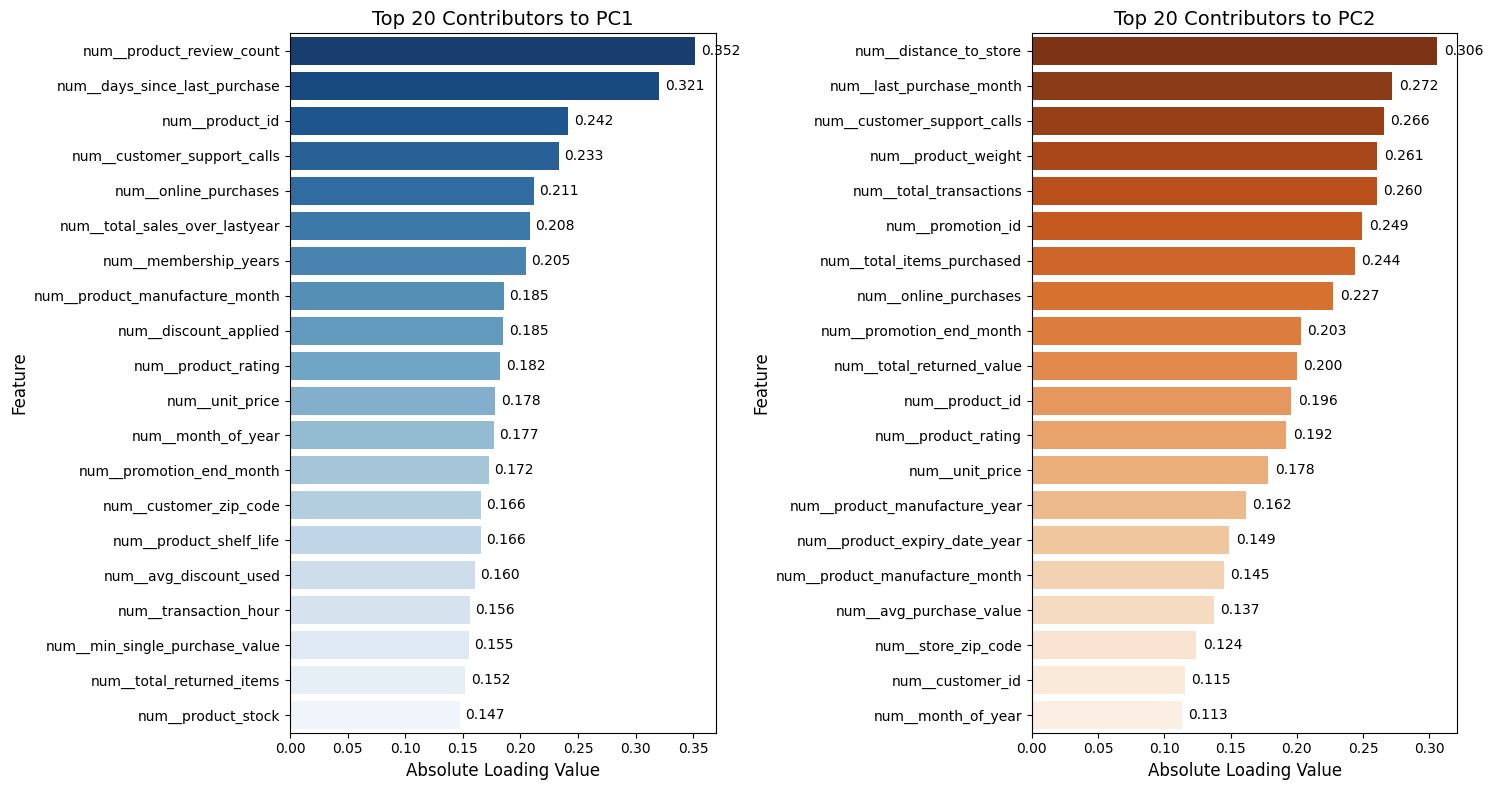

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'loadings' is the DataFrame from your code
# Create figure with two subplots side by side
plt.figure(figsize=(15, 8))

# Top 20 contributors to PC1
top_pc1 = loadings['PC1'].abs().sort_values(ascending=False).head(20)
plt.subplot(1, 2, 1)
ax1 = sns.barplot(x=top_pc1.values, y=top_pc1.index, palette='Blues_r')
plt.title('Top 20 Contributors to PC1', fontsize=14)
plt.xlabel('Absolute Loading Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)

# Add text annotations for PC1 values
for i, value in enumerate(top_pc1.values):
    ax1.text(value + 0.005, i, f'{value:.3f}', va='center', fontsize=10)

# Top 20 contributors to PC2
top_pc2 = loadings['PC2'].abs().sort_values(ascending=False).head(20)
plt.subplot(1, 2, 2)
ax2 = sns.barplot(x=top_pc2.values, y=top_pc2.index, palette='Oranges_r')
plt.title('Top 20 Contributors to PC2', fontsize=14)
plt.xlabel('Absolute Loading Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)

# Add text annotations for PC2 values
for i, value in enumerate(top_pc2.values):
    ax2.text(value + 0.005, i, f'{value:.3f}', va='center', fontsize=10)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()

### Cluster Characteristics (PC1&PC2 Means)

In [ ]:
# Create clustered_data for PCA visualization and analysis
pca_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=2))
])
pca_train = pca_pipeline.fit_transform(train_data.drop(columns=['cluster']))
clustered_data = pd.DataFrame(pca_train, columns=['PC1', 'PC2'])
clustered_data['cluster'] = train_data['cluster'].values

In [ ]:
# Display characteristics for each cluster
for cluster_num in sorted(clustered_data['cluster'].unique()):
    print(f"\nCluster {cluster_num} Characteristics:")

    # Get the data for the specific cluster
    cluster_data = clustered_data[clustered_data['cluster'] == cluster_num]

    # Drop the 'cluster' column to focus on features
    cluster_description = cluster_data.drop(columns=['cluster']).describe().T[['mean', '50%']]

    # Display the characteristics for the current cluster
    print(cluster_description)


Cluster 0 Characteristics:
         mean       50%
PC1  0.474638  0.394609
PC2  0.981074  0.866309

Cluster 1 Characteristics:
         mean       50%
PC1  0.597738  0.503609
PC2 -0.881337 -0.770621

Cluster 2 Characteristics:
         mean       50%
PC1 -1.101827 -1.014222
PC2 -0.063149 -0.044766


In [ ]:
# Compute the mean of PC1 and PC2 for each cluster
cluster_pca_means = clustered_data.groupby('cluster')[['PC1', 'PC2']].mean()

print("\nMean PCA Components per Cluster:")
print(cluster_pca_means)


Mean PCA Components per Cluster:
              PC1       PC2
cluster                    
0        0.474638  0.981074
1        0.597738 -0.881337
2       -1.101827 -0.063149


#### Visual

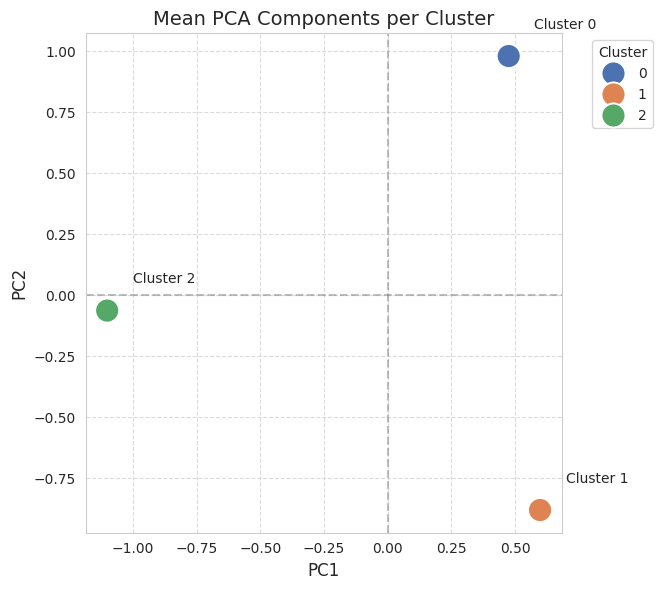

In [ ]:
import matplotlib.pyplot as plt
# Create scatter plot
plt.figure(figsize=(8, 6))
# Use a fixed size for all points
sns.scatterplot(data=cluster_pca_means, x='PC1', y='PC2', hue=cluster_pca_means.index,
                s=300, palette='deep', # Set a fixed size 's' here
                legend='full')
for i, row in cluster_pca_means.iterrows():
    # Adjust text position slightly for readability
    plt.text(row['PC1'] + 0.1, row['PC2'] + 0.1, f'Cluster {i}', fontsize=10, ha='left', va='bottom')
plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
plt.title('Mean PCA Components per Cluster', fontsize=14)
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left') # Adjust legend position
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
plt.show()

### PC1 for each individual attribute (mean)

In [ ]:
pd.set_option('display.max_rows', None)
pd.reset_option('display.max_rows')

import pandas as pd

# Set pandas to display numbers in plain float format
pd.set_option('display.float_format', '{:.6f}'.format)

# Optional: reset to default if needed
# pd.reset_option('display.float_format')

import pandas as pd

# Initialize a DataFrame to store the contributions of each attribute for each cluster
cluster_contributions_pc1 = pd.DataFrame(index=loadings.index, columns=cluster_pca_means.index)

# For each cluster, compute the contribution of each attribute using only PC1
for cluster in cluster_pca_means.index:
    # Get the mean PC1 for this cluster
    pc1_mean = cluster_pca_means.loc[cluster, 'PC1']

    # Compute contribution: (PC1_mean * PC1_loading)
    contributions = pc1_mean * loadings['PC1']

    # Store the contributions for this cluster
    cluster_contributions_pc1[cluster] = contributions

# Rename the columns for clarity
cluster_contributions_pc1.columns = [f'Cluster {i}' for i in cluster_contributions_pc1.columns]

print("\nCluster Characteristics (Contributions of Original Attributes, PC1 Only):")
print(cluster_contributions_pc1)


Cluster Characteristics (Contributions of Original Attributes, PC1 Only):
                                     Cluster 0  Cluster 1  Cluster 2
num__customer_id                     -0.015942  -0.020076   0.037008
num__age                             -0.003513  -0.004424   0.008155
num__membership_years                -0.097108  -0.122293   0.225427
num__number_of_children               0.047933   0.060365  -0.111272
num__transaction_id                  -0.059828  -0.075345   0.138885
...                                        ...        ...        ...
cat__email_subscriptions_Yes          0.003411   0.004295  -0.007918
cat__app_usage_Low                    0.000047   0.000059  -0.000109
cat__app_usage_Medium                -0.000315  -0.000397   0.000731
cat__social_media_engagement_Low      0.000819   0.001031  -0.001901
cat__social_media_engagement_Medium  -0.000821  -0.001034   0.001907

[129 rows x 3 columns]


In [ ]:
pd.set_option('display.max_rows', None)

# Then run your print statement
print(cluster_contributions_pc1)


                                                    Cluster 0  Cluster 1  \
num__customer_id                                    -0.015942  -0.020076   
num__age                                            -0.003513  -0.004424   
num__membership_years                               -0.097108  -0.122293   
num__number_of_children                              0.047933   0.060365   
num__transaction_id                                 -0.059828  -0.075345   
num__product_id                                     -0.114726  -0.144481   
num__quantity                                       -0.000819  -0.001032   
num__unit_price                                      0.084553   0.106482   
num__discount_applied                               -0.087867  -0.110656   
num__transaction_hour                                0.073969   0.093154   
num__week_of_year                                   -0.064130  -0.080763   
num__month_of_year                                  -0.084005  -0.105793   
num__avg_pur

#### Visual

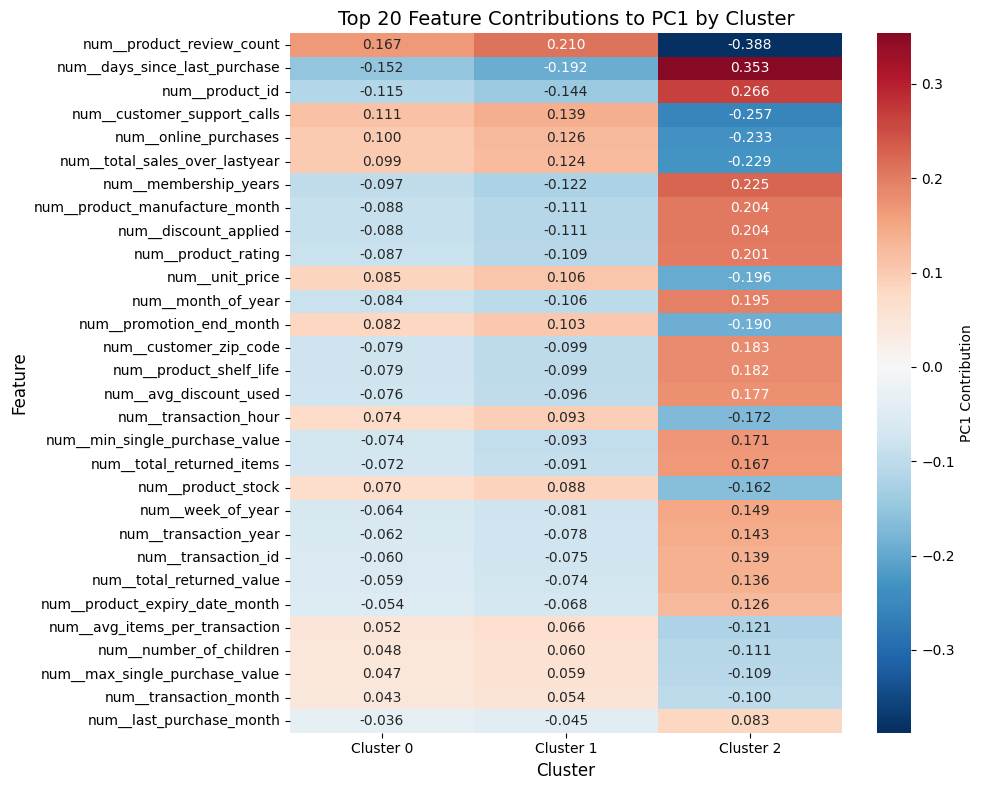

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'cluster_contributions_pc1' and 'loadings' are the DataFrames from your code
# Select top 20 features based on absolute PC1 loadings from earlier data
top_pc1_features = loadings['PC1'].abs().sort_values(ascending=False).head(30).index
top_contributions = cluster_contributions_pc1.loc[top_pc1_features]

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(top_contributions, annot=True, fmt='.3f', cmap='RdBu_r',
            center=0, cbar_kws={'label': 'PC1 Contribution'})
plt.title('Top 20 Feature Contributions to PC1 by Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

### PC2 for each indivudal attribute (mean)

In [ ]:
pd.set_option('display.max_rows', None)
pd.reset_option('display.max_rows')

import pandas as pd

# Set pandas to display numbers in plain float format
pd.set_option('display.float_format', '{:.6f}'.format)

# Optional: reset to default if needed
# pd.reset_option('display.float_format')

import pandas as pd

# Initialize a DataFrame to store the contributions of each attribute for each cluster
cluster_contributions_pc2 = pd.DataFrame(index=loadings.index, columns=cluster_pca_means.index)

# For each cluster, compute the contribution of each attribute using only PC1
for cluster in cluster_pca_means.index:
    # Get the mean PC1 for this cluster
    pc2_mean = cluster_pca_means.loc[cluster, 'PC2']

    # Compute contribution: (PC1_mean * PC1_loading)
    contributions = pc2_mean * loadings['PC2']

    # Store the contributions for this cluster
    cluster_contributions_pc2[cluster] = contributions

# Rename the columns for clarity
cluster_contributions_pc2.columns = [f'Cluster {i}' for i in cluster_contributions_pc2.columns]

print("\nCluster Characteristics (Contributions of Original Attributes, PC2 Only):")
print(cluster_contributions_pc2)


Cluster Characteristics (Contributions of Original Attributes, PC2 Only):
                                     Cluster 0  Cluster 1  Cluster 2
num__customer_id                      0.113073  -0.101578  -0.007278
num__age                              0.108621  -0.097578  -0.006992
num__membership_years                 0.053172  -0.047766  -0.003423
num__number_of_children              -0.096232   0.086449   0.006194
num__transaction_id                  -0.004029   0.003620   0.000259
...                                        ...        ...        ...
cat__email_subscriptions_Yes         -0.000106   0.000095   0.000007
cat__app_usage_Low                    0.005889  -0.005291  -0.000379
cat__app_usage_Medium                -0.003688   0.003313   0.000237
cat__social_media_engagement_Low      0.004344  -0.003902  -0.000280
cat__social_media_engagement_Medium  -0.003158   0.002837   0.000203

[129 rows x 3 columns]


In [ ]:
pd.set_option('display.max_rows', None)

# Then run your print statement
print(cluster_contributions_pc2)


                                                    Cluster 0  Cluster 1  \
num__customer_id                                     0.113073  -0.101578   
num__age                                             0.108621  -0.097578   
num__membership_years                                0.053172  -0.047766   
num__number_of_children                             -0.096232   0.086449   
num__transaction_id                                 -0.004029   0.003620   
num__product_id                                      0.192158  -0.172623   
num__quantity                                        0.005705  -0.005125   
num__unit_price                                      0.174889  -0.157109   
num__discount_applied                                0.053866  -0.048390   
num__transaction_hour                                0.088680  -0.079665   
num__week_of_year                                    0.088383  -0.079398   
num__month_of_year                                  -0.110862   0.099591   
num__avg_pur

#### Visual

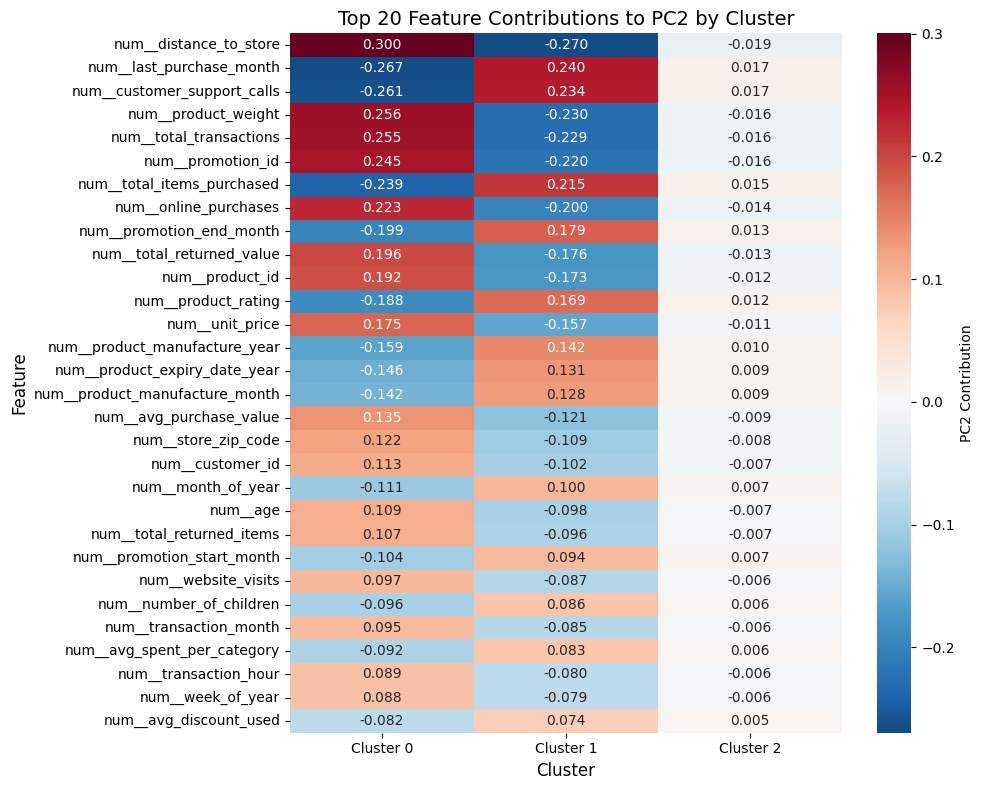

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'cluster_contributions_pc1' and 'loadings' are the DataFrames from your code
# Select top 20 features based on absolute PC1 loadings from earlier data
top_pc2_features = loadings['PC2'].abs().sort_values(ascending=False).head(30).index
top_contributions2 = cluster_contributions_pc2.loc[top_pc2_features]

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(top_contributions2, annot=True, fmt='.3f', cmap='RdBu_r',
            center=0, cbar_kws={'label': 'PC2 Contribution'})
plt.title('Top 20 Feature Contributions to PC2 by Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

### Cluster Characteristics Visual

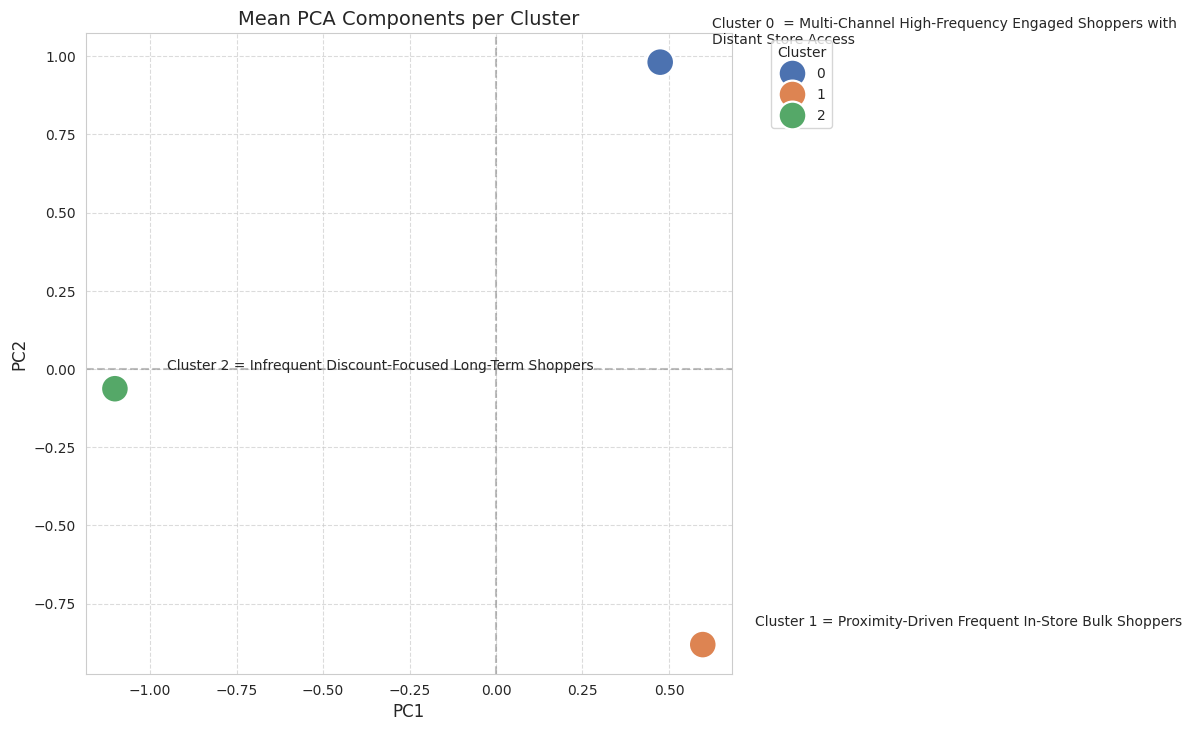

In [ ]:
import matplotlib.pyplot as plt
# Use the provided cluster names
cluster_names = [
    'Cluster 0  = Multi-Channel High-Frequency Engaged Shoppers with Distant Store Access',
    'Cluster 1 = Proximity-Driven Frequent In-Store Bulk Shoppers',
    'Cluster 2 = Infrequent Discount-Focused Long-Term Shoppers'
]

# Create scatter plot
# Increase the figure width for a wider graph
plt.figure(figsize=(12, 8))
# Use a fixed size for all points
sns.scatterplot(data=cluster_pca_means, x='PC1', y='PC2', hue=cluster_pca_means.index,
                s=400, palette='deep', # Increased size 's' slightly for better visibility
                legend='full')

# Add text labels using the cluster_names
for i, row in cluster_pca_means.iterrows():
    # Ensure the index 'i' maps correctly to the cluster_names list index
    if i < len(cluster_names):
        # Adjust text position slightly for readability
        plt.text(row['PC1'] + 0.15, row['PC2'] + 0.05, cluster_names[i],
                 fontsize=10, ha='left', va='bottom', wrap=True) # Added wrap=True

plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
plt.title('Mean PCA Components per Cluster', fontsize=14)
plt.xlabel('PC1', fontsize=12)
plt.ylabel('PC2', fontsize=12)
# Keep the legend as is, mapping cluster number to color
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left') # Adjust legend position
plt.grid(True, linestyle='--', alpha=0.7)
# Adjust layout to make space for legend and potentially longer text labels
plt.tight_layout(rect=[0, 0, 0.75, 1]) # Increased space for text labels and legend
plt.show()


# RQ2 - Monte Carlo Simulation

In [ ]:
#Total Sales Revenue Formula = total_sales_revenue = ((avg_transaction_value * total_transactions - total_returned_value - total_discounts_received) * (1 - churned))

#Goal: Estimate Total Sales Revenue per Cluster

## Normality Check

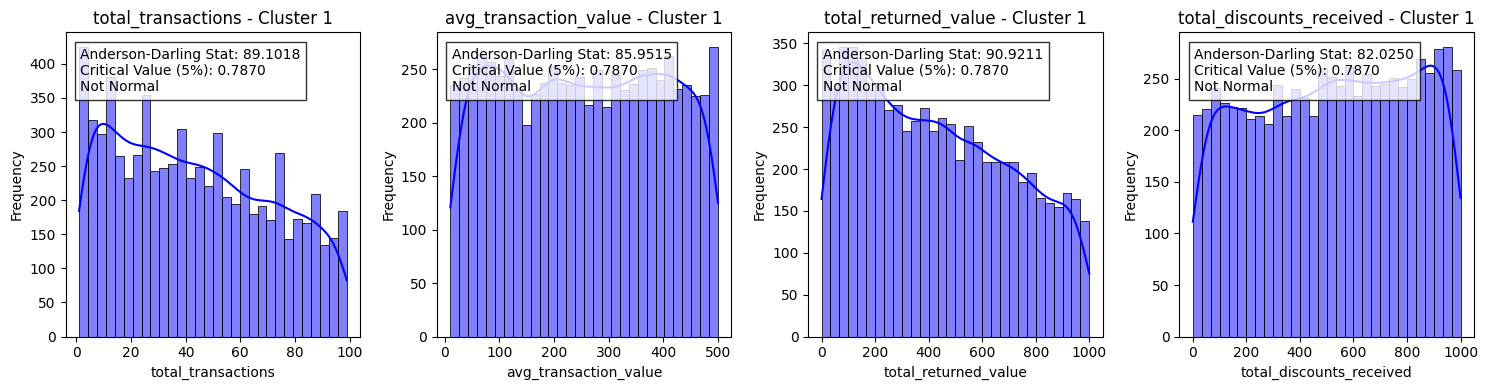

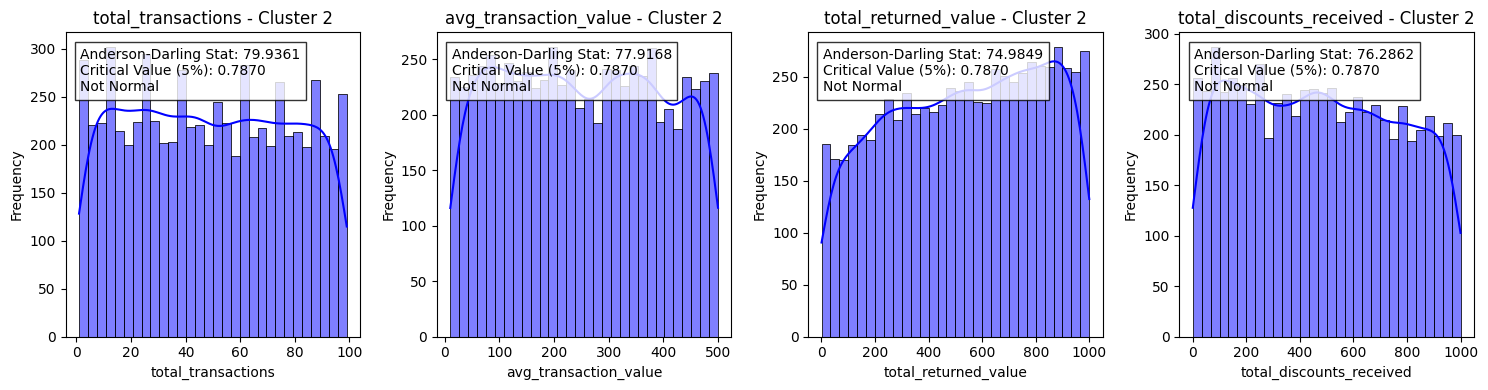

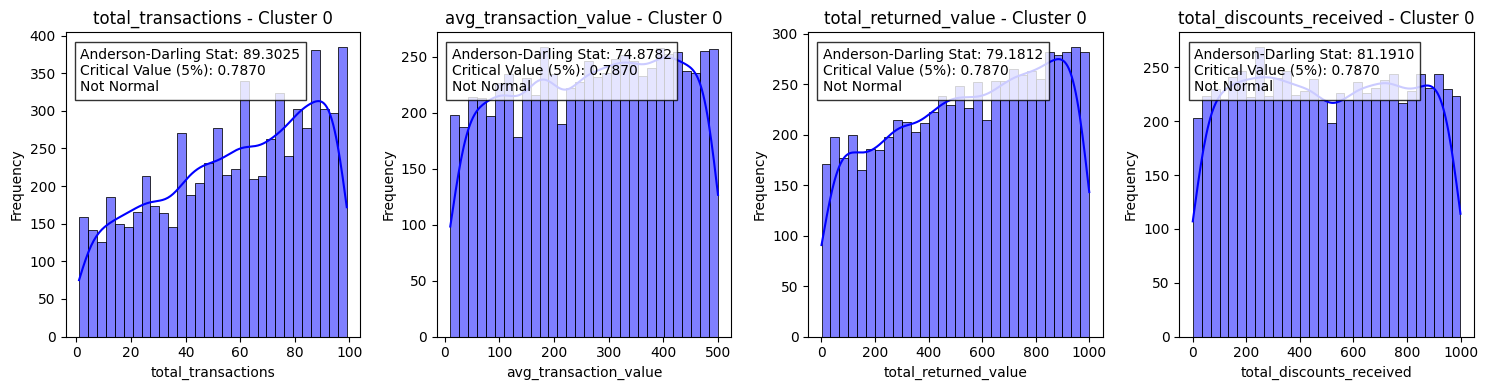

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import anderson
import seaborn as sns

# Assuming train_data is already loaded
def validate_distributions(cluster_data, cluster_id):
    variables = ['total_transactions', 'avg_transaction_value', 'total_returned_value', 'total_discounts_received']

    plt.figure(figsize=(15, 4))
    for i, var in enumerate(variables, 1):
        # Histogram with KDE
        plt.subplot(1, 4, i)
        sns.histplot(cluster_data[var], kde=True, color='blue', bins=30)
        plt.title(f'{var} - Cluster {cluster_id}')
        plt.xlabel(var)
        plt.ylabel('Frequency')

        # Anderson-Darling test for normality
        result = anderson(cluster_data[var], dist='norm')
        stat = result.statistic
        critical_value = result.critical_values[2]  # Using 5% significance level
        normality_text = f'Anderson-Darling Stat: {stat:.4f}\nCritical Value (5%): {critical_value:.4f}\n'
        normality_text += "Normal" if stat < critical_value else "Not Normal"
        plt.text(0.05, 0.95, normality_text, transform=plt.gca().transAxes,
                 fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

# Example usage within your loop
for cluster_id in train_data['cluster'].unique():
    cluster_data = train_data[train_data['cluster'] == cluster_id]
    if cluster_data.empty:
        print(f"Cluster {cluster_id} has no data, skipping.")
        continue
    validate_distributions(cluster_data, cluster_id)

In [ ]:
from scipy.stats import anderson
import pandas as pd

# Assuming cluster_data is a pandas DataFrame for a specific cluster
def check_normality(cluster_data, cluster_id):
    variables = ['total_transactions', 'avg_transaction_value', 'total_returned_value', 'total_discounts_received']

    for var in variables:
        if var not in cluster_data.columns:
            print(f"Variable {var} not found in cluster_data for Cluster {cluster_id}, skipping.")
            continue

        # Perform Anderson-Darling test
        result = anderson(cluster_data[var], dist='norm')
        stat = result.statistic
        critical_value = result.critical_values[2]  # 5% significance level
        print(f"\nAnderson-Darling test for {var} in Cluster {cluster_id}:")
        print(f"Statistic: {stat:.4f}, Critical Value (5%): {critical_value:.4f}")
        if stat > critical_value:
            print(f"{var} is not normally distributed; consider log-normal or gamma.")
        else:
            print(f"{var} appears normally distributed (cannot reject normality).")

# Example usage within your cluster loop
for cluster_id in train_data['cluster'].unique():
    cluster_data = train_data[train_data['cluster'] == cluster_id]
    if cluster_data.empty:
        print(f"Cluster {cluster_id} has no data, skipping.")
        continue
    print(f"\nTesting Normality for Cluster {cluster_id}")
    check_normality(cluster_data, cluster_id)


Testing Normality for Cluster 1

Anderson-Darling test for total_transactions in Cluster 1:
Statistic: 89.1018, Critical Value (5%): 0.7870
total_transactions is not normally distributed; consider log-normal or gamma.

Anderson-Darling test for avg_transaction_value in Cluster 1:
Statistic: 85.9515, Critical Value (5%): 0.7870
avg_transaction_value is not normally distributed; consider log-normal or gamma.

Anderson-Darling test for total_returned_value in Cluster 1:
Statistic: 90.9211, Critical Value (5%): 0.7870
total_returned_value is not normally distributed; consider log-normal or gamma.

Anderson-Darling test for total_discounts_received in Cluster 1:
Statistic: 82.0250, Critical Value (5%): 0.7870
total_discounts_received is not normally distributed; consider log-normal or gamma.

Testing Normality for Cluster 2

Anderson-Darling test for total_transactions in Cluster 2:
Statistic: 79.9361, Critical Value (5%): 0.7870
total_transactions is not normally distributed; consider log

## The one, improve visuals


Testing Normality for Cluster 1
Anderson-Darling test for total_transactions in Cluster 1:
Statistic: 89.1018, Critical Value (5%): 0.7870
total_transactions is not normally distributed; consider log-normal or gamma.
Anderson-Darling test for avg_transaction_value in Cluster 1:
Statistic: 85.9515, Critical Value (5%): 0.7870
avg_transaction_value is not normally distributed; consider log-normal or gamma.
Anderson-Darling test for total_returned_value in Cluster 1:
Statistic: 90.9211, Critical Value (5%): 0.7870
total_returned_value is not normally distributed; consider log-normal or gamma.
Anderson-Darling test for total_discounts_received in Cluster 1:
Statistic: 82.0250, Critical Value (5%): 0.7870
total_discounts_received is not normally distributed; consider log-normal or gamma.
Churn Probability for Cluster 1: 0.4936
Average Discount-to-Transaction-Value Ratio (Cluster 1): 0.0470
Negative revenue simulations before clipping (Cluster 1): 2616
Mean Revenue for Non-Churned Customers

<ipython-input-22-1497635375>:164: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  box_plot = sns.boxplot(x='Cluster', y='Revenue', data=all_simulated_revenues_df, palette=palette)


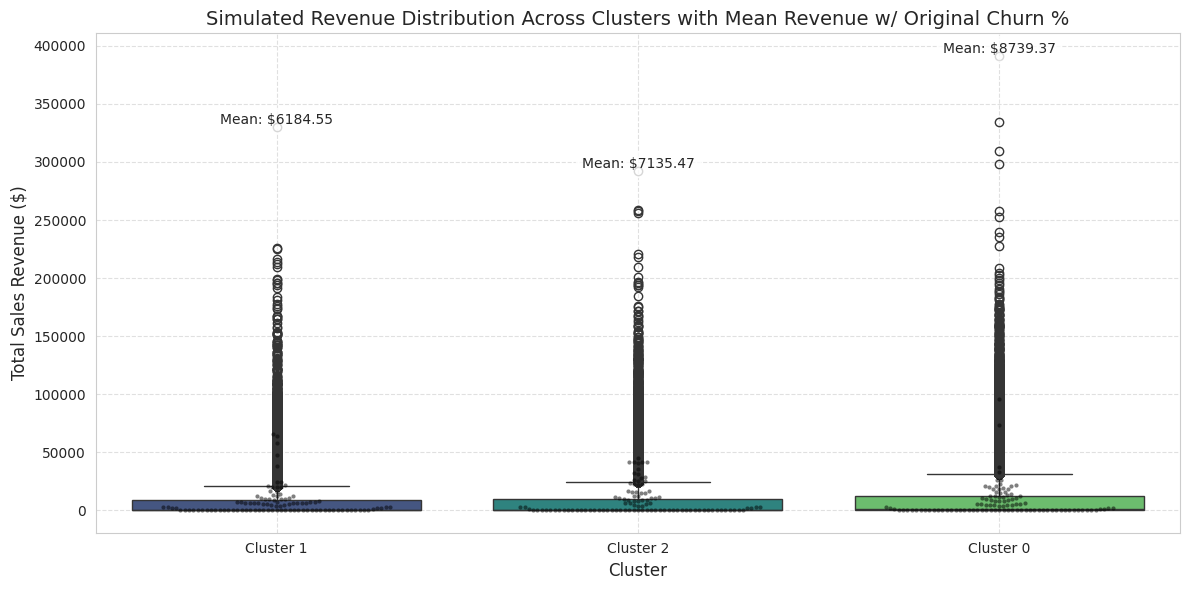

<ipython-input-22-1497635375>:202: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='Cluster', y='Mean_Revenue', data=non_churn_stats_df, palette=palette, edgecolor='black')


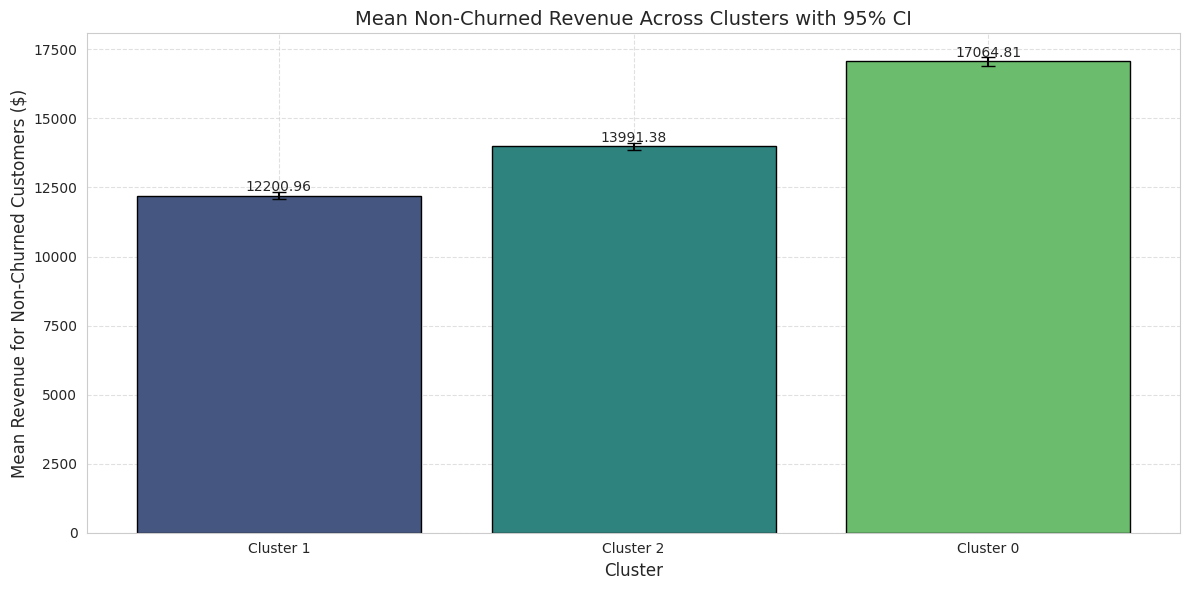

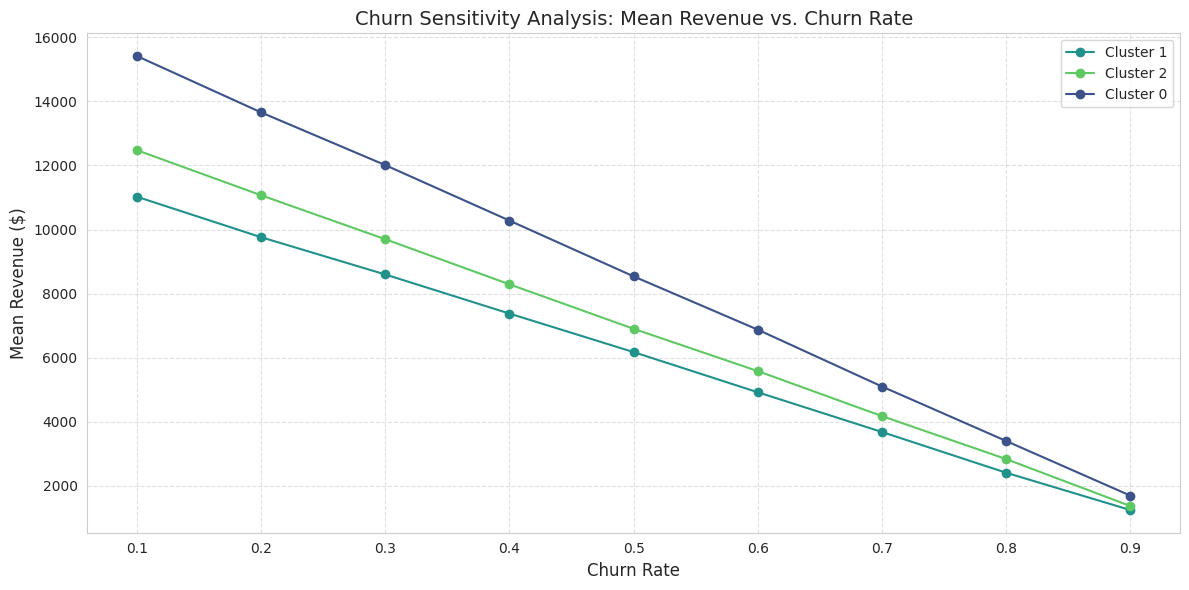

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import anderson, multivariate_normal, poisson

# Check train_data and cluster column
if 'train_data' not in globals() or train_data.empty:
    raise ValueError("train_data is not loaded or is empty!")
if 'cluster' not in train_data.columns:
    raise ValueError("Column 'cluster' not found in train_data!")

np.random.seed(42)  # For reproducibility
num_simulations = 100000
sns.set_style("whitegrid")  # Set Seaborn style for better aesthetics
palette = sns.color_palette("viridis", n_colors=len(train_data['cluster'].unique()))  # Consistent color palette

# Initialize lists to store results for cross-cluster visualizations
all_simulated_revenues = []
all_non_churn_revenues = []
churn_sensitivity_results = []

def lognormal_params(mean, std):
    if mean <= 0 or std <= 0:
        raise ValueError("Mean and std must be positive for log-normal.")
    mu = np.log(mean**2 / np.sqrt(std**2 + mean**2))
    sigma = np.sqrt(np.log(1 + (std**2 / mean**2)))
    return mu, sigma

def validate_distributions(cluster_data, cluster_id):
    variables = ['total_transactions', 'avg_transaction_value', 'total_returned_value', 'total_discounts_received']
    print(f"\nTesting Normality for Cluster {cluster_id}")
    for var in variables:
        if var not in cluster_data.columns:
            print(f"Variable {var} not found in cluster_data for Cluster {cluster_id}, skipping.")
            continue
        stat = anderson(cluster_data[var], dist='norm')
        crit_value = stat.critical_values[2]  # 5% significance level
        print(f"Anderson-Darling test for {var} in Cluster {cluster_id}:")
        print(f"Statistic: {stat.statistic:.4f}, Critical Value (5%): {crit_value:.4f}")
        if stat.statistic > crit_value:
            print(f"{var} is not normally distributed; consider log-normal or gamma.")
        else:
            print(f"{var} appears normally distributed.")

for cluster_id in train_data['cluster'].unique():
    cluster_data = train_data[train_data['cluster'] == cluster_id]
    if cluster_data.empty:
        print(f"Cluster {cluster_id} has no data, skipping.")
        continue

    # Validate distributions
    validate_distributions(cluster_data, cluster_id)

    # Compute parameters
    trans_mean = cluster_data['total_transactions'].mean()
    avg_value_mean = cluster_data['avg_transaction_value'].mean()
    avg_value_std = cluster_data['avg_transaction_value'].std()
    avg_value_min = cluster_data['avg_transaction_value'].min()
    return_mean = cluster_data['total_returned_value'].mean()
    return_std = cluster_data['total_returned_value'].std()
    return_min = cluster_data['total_returned_value'].min()
    discount_mean = cluster_data['total_discounts_received'].mean()
    discount_std = cluster_data['total_discounts_received'].std()
    discount_min = cluster_data['total_discounts_received'].min()
    churn_prob = (cluster_data['churned'] == 'Yes').mean()

    print(f"Churn Probability for Cluster {cluster_id}: {churn_prob:.4f}")
    print(f"Average Discount-to-Transaction-Value Ratio (Cluster {cluster_id}): {discount_mean / (avg_value_mean * trans_mean):.4f}")

    # Log-normal parameters for avg_transaction_value, total_returned_value, and total_discounts_received
    avg_value_mu, avg_value_sigma = lognormal_params(avg_value_mean, avg_value_std)
    return_mu, return_sigma = lognormal_params(return_mean, return_std)
    discount_mu, discount_sigma = lognormal_params(discount_mean, discount_std)

    # Compute covariance matrix for log-transformed variables
    log_avg_value = np.log(cluster_data['avg_transaction_value'].clip(avg_value_min))
    log_return = np.log(cluster_data['total_returned_value'].clip(return_min))
    log_discount = np.log(cluster_data['total_discounts_received'].clip(discount_min))
    cov_matrix = pd.DataFrame({
        'log_avg_transaction_value': log_avg_value,
        'log_total_returned_value': log_return,
        'log_total_discounts_received': log_discount
    }).cov().values

    # Simulate correlated log-normal variables
    correlated_vars = multivariate_normal.rvs(
        mean=[avg_value_mu, return_mu, discount_mu],
        cov=cov_matrix,
        size=num_simulations
    )

    # Extract and transform
    avg_value = np.maximum(np.exp(correlated_vars[:, 0]), avg_value_min)
    total_returned_value = np.maximum(np.exp(correlated_vars[:, 1]), return_min)
    total_discounts_received = np.maximum(np.exp(correlated_vars[:, 2]), discount_min)

    # Simulate total_transactions using Poisson
    transactions = poisson.rvs(mu=trans_mean, size=num_simulations)
    transactions = np.maximum(transactions, 1)  # Ensure at least 1 transaction

    # Induce correlation with avg_transaction_value
    corr_target = cluster_data[['total_transactions', 'avg_transaction_value']].corr().iloc[0, 1]
    if abs(corr_target) > 0.1:  # Only adjust if correlation is meaningful
        avg_value_ranks = np.argsort(np.argsort(avg_value))
        transactions_sorted = np.sort(transactions)
        transactions = transactions_sorted[np.argsort(avg_value_ranks)]

    # Simulate churn
    churned = np.random.binomial(n=1, p=churn_prob, size=num_simulations)

    # Calculate total sales revenue
    raw_revenue = (avg_value * transactions - total_returned_value - total_discounts_received)
    negative_revenues = np.sum(raw_revenue < 0)
    print(f"Negative revenue simulations before clipping (Cluster {cluster_id}): {negative_revenues}")
    total_sales_revenue = np.maximum(raw_revenue * (1 - churned), 0)

    # Non-churned revenue analysis
    non_churn_revenue = raw_revenue[churned == 0]  # Use 0 for 'No' churn
    print(f"Mean Revenue for Non-Churned Customers (Cluster {cluster_id}): {np.mean(non_churn_revenue):.2f}")
    print(f"Median Revenue for Non-Churned Customers (Cluster {cluster_id}): {np.median(non_churn_revenue):.2f}")

    # Churn Sensitivity Analysis (10% to 90%)
    print(f"\nChurn Sensitivity Analysis for Cluster {cluster_id}:")
    churn_rates = np.arange(0.1, 1.0, 0.1)  # 10% to 90%
    mean_revenues = []
    for churn_rate in churn_rates:
        churned_scaled = np.random.binomial(n=1, p=churn_rate, size=num_simulations)
        revenue_scaled = np.maximum(raw_revenue * (1 - churned_scaled), 0)
        mean_revenue = np.mean(revenue_scaled)
        mean_revenues.append(mean_revenue)
        print(f"Mean Revenue with Churn Rate {churn_rate:.1f}: {mean_revenue:.2f}")
        churn_sensitivity_results.append({
            'Cluster': cluster_id,
            'Churn_Rate': churn_rate,
            'Mean_Revenue': mean_revenue
        })

    # Store for visualizations
    all_simulated_revenues.append(pd.DataFrame({
        'Revenue': total_sales_revenue,
        'Cluster': f"Cluster {cluster_id}"
    }))
    all_non_churn_revenues.append(pd.DataFrame({
        'Revenue': non_churn_revenue,
        'Cluster': f"Cluster {cluster_id}"
    }))

    # Save results
    results_df = pd.DataFrame({'total_sales_revenue': total_sales_revenue})
    results_df.to_csv(f"cluster_{cluster_id}_revenue_simulation.csv", index=False)

    # Print summary statistics
    print(f"\nTotal Sales Revenue for Cluster {cluster_id} (First 10 Entries):")
    print(total_sales_revenue[:10])
    print(f"Mean of Total Sales Revenue (Cluster {cluster_id}): {np.mean(total_sales_revenue):.2f}")
    print(f"Median of Total Sales Revenue (Cluster {cluster_id}): {np.median(total_sales_revenue):.2f}")
    print(f"5th Percentile: {np.percentile(total_sales_revenue, 5):.2f}")
    print(f"95th Percentile: {np.percentile(total_sales_revenue, 95):.2f}")

# Visualization 1: Enhanced Box Plot of Simulated Revenue Across Clusters (Mean Only)
all_simulated_revenues_df = pd.concat(all_simulated_revenues)
plt.figure(figsize=(12, 6))
box_plot = sns.boxplot(x='Cluster', y='Revenue', data=all_simulated_revenues_df, palette=palette)
sample_size = 100
for cluster in all_simulated_revenues_df['Cluster'].unique():
    cluster_data = all_simulated_revenues_df[all_simulated_revenues_df['Cluster'] == cluster]['Revenue']
    if len(cluster_data) > sample_size:
        sample_data = cluster_data.sample(sample_size, random_state=42)
    else:
        sample_data = cluster_data
    sns.swarmplot(x=[cluster] * len(sample_data), y=sample_data, color='black', size=3, alpha=0.5)
for i, cluster in enumerate(all_simulated_revenues_df['Cluster'].unique()):
    cluster_data = all_simulated_revenues_df[all_simulated_revenues_df['Cluster'] == cluster]['Revenue']
    mean_rev = cluster_data.mean()
    box_plot.text(i, cluster_data.max() + 100, f'Mean: ${mean_rev:.2f}',
                  ha='center', va='bottom', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
plt.title("Simulated Revenue Distribution Across Clusters with Mean Revenue w/ Original Churn %", fontsize=14)
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Total Sales Revenue ($)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Visualization 2: Bar Plot of Mean Non-Churned Revenue with Confidence Intervals
all_non_churn_revenues_df = pd.concat(all_non_churn_revenues)
non_churn_stats = []
for cluster_id in train_data['cluster'].unique():
    non_churn_data = all_non_churn_revenues_df[all_non_churn_revenues_df['Cluster'] == f"Cluster {cluster_id}"]
    if not non_churn_data.empty:
        mean_rev = non_churn_data['Revenue'].mean()
        std_err = non_churn_data['Revenue'].std() / np.sqrt(len(non_churn_data))
        ci = 1.96 * std_err  # 95% CI
        non_churn_stats.append({
            'Cluster': f"Cluster {cluster_id}",
            'Mean_Revenue': mean_rev,
            'CI_Lower': mean_rev - ci,
            'CI_Upper': mean_rev + ci
        })
non_churn_stats_df = pd.DataFrame(non_churn_stats)
plt.figure(figsize=(12, 6))
bars = sns.barplot(x='Cluster', y='Mean_Revenue', data=non_churn_stats_df, palette=palette, edgecolor='black')
for i, row in non_churn_stats_df.iterrows():
    plt.errorbar(i, row['Mean_Revenue'], yerr=[[row['Mean_Revenue'] - row['CI_Lower']], [row['CI_Upper'] - row['Mean_Revenue']]],
                 fmt='none', c='black', capsize=5)
for bar, mean in zip(bars.patches, non_churn_stats_df['Mean_Revenue']):
    bars.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, f'{mean:.2f}',
              ha='center', va='bottom', fontsize=10)
plt.title("Mean Non-Churned Revenue Across Clusters with 95% CI", fontsize=14)
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Mean Revenue for Non-Churned Customers ($)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Visualization 3: Churn Sensitivity Analysis Plot
churn_sensitivity_df = pd.DataFrame(churn_sensitivity_results)
plt.figure(figsize=(12, 6))
for cluster_id in churn_sensitivity_df['Cluster'].unique():
    cluster_data = churn_sensitivity_df[churn_sensitivity_df['Cluster'] == cluster_id]
    plt.plot(cluster_data['Churn_Rate'], cluster_data['Mean_Revenue'], marker='o', label=f"Cluster {cluster_id}", color=palette[cluster_id])
plt.title("Churn Sensitivity Analysis: Mean Revenue vs. Churn Rate", fontsize=14)
plt.xlabel("Churn Rate", fontsize=12)
plt.ylabel("Mean Revenue ($)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()